In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotnine as p9
import mizani
import numpy as np
plt.style.use('ggplot')

In [2]:
jhu_daily_data = "../data/daily.df"
jhu = pd.read_pickle(jhu_daily_data)

jhu['Date'] = jhu['Date'].apply(lambda x: x.to_timestamp()) 
jhu['Last_Update'] = pd.to_datetime(jhu['Last_Update'])

## Preprocessing John Hopkins University Data

* Extract Data for only US
* Fix State columns (the format of data changed from January to May)
* Combine data per state (JHU data is at county level)

In [3]:
#jhu.dropna(subset=['FIPS'], inplace=True)

#Selecting only US Data:
#jhu['Counrty/Region'] = jhu['Country_Region']
jhu1 = jhu.loc[jhu['Country/Region'] == 'US']
jhu2 = jhu.loc[jhu['Country_Region'] == 'US']
jhus=[jhu1,jhu2]

jhus = pd.concat(jhus)

print(jhus.shape)

#Fill NaN values in 'Province/State' column with 'Province_State' values
jhus['Province/State'].fillna(jhus['Province_State'], inplace=True)

#Discard data about Diamond Princess and Guam (b/c no safeGraph data)
jhus=jhus[~jhus['Province/State'].str.contains('Princess')]
jhus=jhus[~jhus['Province/State'].str.contains('Guam')]
print("After dropping Guam and Diamond Princess:", jhus.shape)

states_abb = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "D.C.", "DE", "FL", "GA", 
              "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
              "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
              "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
              "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY", "Puerto Rico"]

states = ["Alabama","Alaska","Arizona","Arkansas","California","Colorado",
          "Connecticut","District of Columbia","District of Columbia","Delaware",
          "Florida","Georgia","Hawaii","Idaho","Illinois","Indiana","Iowa","Kansas",
          "Kentucky","Louisiana","Maine","Maryland","Massachusetts","Michigan",
          "Minnesota","Mississippi","Missouri","Montana","Nebraska","Nevada",
          "New Hampshire","New Jersey","New Mexico","New York","North Carolina",
          "North Dakota","Ohio","Oklahoma","Oregon","Pennsylvania","Rhode Island",
          "South Carolina","South Dakota","Tennessee","Texas","Utah","Vermont",
          "Virginia","Washington","West Virginia","Wisconsin","Wyoming", "Puerto Rico"]

for i in range(len(states_abb)):
    idx = jhus['Province/State'].str.contains(states_abb[i])
    jhus.loc[idx,'Province_State'] = states[i]

for i in range(len(states)):
    idx = jhus['Province/State'].str.contains(states[i])
    jhus.loc[idx,('Province_State')] = states[i]    

#Find rows that do not contain valid State Names (e.g. Virgin Islands, American Samoa)
idx = ~jhus['Province_State'].isin(states)
jhus.loc[idx,('Province_State')] = np.NaN

#Drop remaining NaN Values in Province_State (this discards data from Virgin Islands)
jhus.dropna(subset=['Province_State'], inplace=True)
print("after dropping NaN:", jhus.shape)

jhus.head()

(152067, 18)
After dropping Guam and Diamond Princess: (151808, 18)
after dropping NaN: (151626, 18)


,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Date,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Active,Combined_Key,Latitude,Longitude
69,"Chicago, IL",US,2020-02-09T19:03:03,2.0,0.0,2.0,2020-02-26,NaN,NaN,Illinois,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
70,"San Benito, CA",US,2020-02-03T03:53:02,2.0,0.0,0.0,2020-02-26,NaN,NaN,California,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
71,"San Diego County, CA",US,2020-02-21T05:43:02,2.0,0.0,1.0,2020-02-26,NaN,NaN,California,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
72,"Santa Clara, CA",US,2020-02-21T05:23:04,2.0,0.0,1.0,2020-02-26,NaN,NaN,California,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
89,"Boston, MA",US,2020-02-01T19:43:03,1.0,0.0,0.0,2020-02-26,NaN,NaN,Massachusetts,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
print('Total number of states:', jhus['Province_State'].nunique())

Total number of states: 52


In [11]:
# Total cases in US daily:
jhu_totals = jhus.groupby('Date').sum().reset_index()

# Daily cases per State:
jhu_state = jhus.groupby(['Date','Province_State']).sum().reset_index()

# Last reported number of cases per State:
date = jhu_state.nlargest(1,'Date')
print(date['Date'])

latest = jhu_state.loc[jhu_state['Date'] == '2020-05-13'] #change according to date as new data is downloaded
latest.head()

3729   2020-05-13
Name: Date, dtype: datetime64[ns]


,Date,Province_State,Confirmed,Deaths,Recovered,FIPS,Lat,Long_,Active,Latitude,Longitude
3729,2020-05-13,Alabama,10700.0,450.0,0.0,161490.0,2203.246784,-5809.578199,10250.0,0.0,0.0
3730,2020-05-13,Alaska,383.0,10.0,0.0,120167.0,845.536396,-2035.571369,373.0,0.0,0.0
3731,2020-05-13,Arizona,12216.0,595.0,0.0,150212.0,505.138555,-1671.948482,11621.0,0.0,0.0
3732,2020-05-13,Arkansas,4236.0,97.0,0.0,460536.0,2551.131960,-6745.813940,4139.0,0.0,0.0
3733,2020-05-13,California,72798.0,2957.0,0.0,423195.0,2073.109871,-6640.420400,69841.0,0.0,0.0


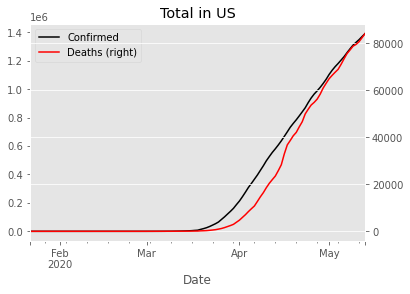

In [12]:
ax = jhu_totals.plot(x='Date',y='Confirmed',c='k',title='Total in US')
_ = jhu_totals.plot(x='Date',y='Deaths',secondary_y=True,ax=ax,c='r')

In [13]:
print(jhu_state.shape)
jhu_state.head()

#ax = jhu_state.plot(x='Date',y='Confirmed',c='k')
#_ = jhu_totals.plot(x='Date',y='Deaths',secondary_y=True,ax=ax,c='r')

(3781, 11)


,Date,Province_State,Confirmed,Deaths,Recovered,FIPS,Lat,Long_,Active,Latitude,Longitude
0,2020-01-22,Washington,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-01-23,Washington,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-24,Washington,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-25,Illinois,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-01-25,Washington,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
jhu_state.tail()

,Date,Province_State,Confirmed,Deaths,Recovered,FIPS,Lat,Long_,Active,Latitude,Longitude
3776,2020-05-13,Virginia,26746.0,928.0,0.0,6908162.0,4996.297993,-10442.323661,25818.0,0.0,0.0
3777,2020-05-13,Washington,17512.0,974.0,0.0,2158574.0,1842.117670,-4708.049596,16538.0,0.0,0.0
3778,2020-05-13,West Virginia,1398.0,58.0,0.0,2900948.0,2018.176519,-4191.713732,1340.0,0.0,0.0
3779,2020-05-13,Wisconsin,10902.0,421.0,0.0,3889975.0,3060.112788,-6193.512168,10481.0,0.0,0.0
3780,2020-05-13,Wyoming,688.0,7.0,0.0,1322540.0,947.158755,-2359.957083,681.0,0.0,0.0


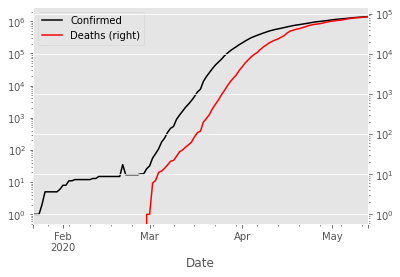

In [15]:
ax = jhu_totals.plot(x='Date',y='Confirmed',c='k',logy=True)
_ = jhu_totals.plot(x='Date',y='Deaths',secondary_y=True,ax=ax,c='r',logy=True)

In [28]:
# 10 States with largest number of Confirmed cases today:
jhu_largest_state = latest.nlargest(10,'Confirmed')
print('Top 10 States with highest confirmed Cases')
jhu_largest_state

Top 10 States with highest confirmed Cases


,Date,Province_State,Confirmed,Deaths,Recovered,FIPS,Lat,Long_,Active,Latitude,Longitude
3761,2020-05-13,New York,340661.0,27477.0,0.0,2181662.0,2474.952404,-4383.622249,313184.0,0.0,0.0
3759,2020-05-13,New Jersey,141560.0,9714.0,0.0,804475.0,846.015259,-1567.071444,131846.0,0.0,0.0
3742,2020-05-13,Illinois,84694.0,3792.0,0.0,1863067.0,3943.523816,-8828.677000,80902.0,0.0,0.0
3750,2020-05-13,Massachusetts,80497.0,5315.0,0.0,390195.0,548.293200,-930.501649,75182.0,0.0,0.0
3733,2020-05-13,California,72798.0,2957.0,0.0,423195.0,2073.109871,-6640.420400,69841.0,0.0,0.0
3767,2020-05-13,Pennsylvania,62101.0,4094.0,0.0,2908531.0,2734.811250,-5200.226295,58007.0,0.0,0.0
3751,2020-05-13,Michigan,48391.0,4714.0,0.0,2256784.0,3515.365820,-6806.532423,43677.0,0.0,0.0
3773,2020-05-13,Texas,43020.0,1172.0,0.0,10705018.0,6966.061599,-21629.392386,41848.0,0.0,0.0
3738,2020-05-13,Florida,42402.0,1827.0,0.0,898562.0,1939.030577,-5540.949842,40575.0,0.0,0.0
3739,2020-05-13,Georgia,35427.0,1517.0,0.0,2262703.0,5216.556611,-13288.811358,33910.0,0.0,0.0


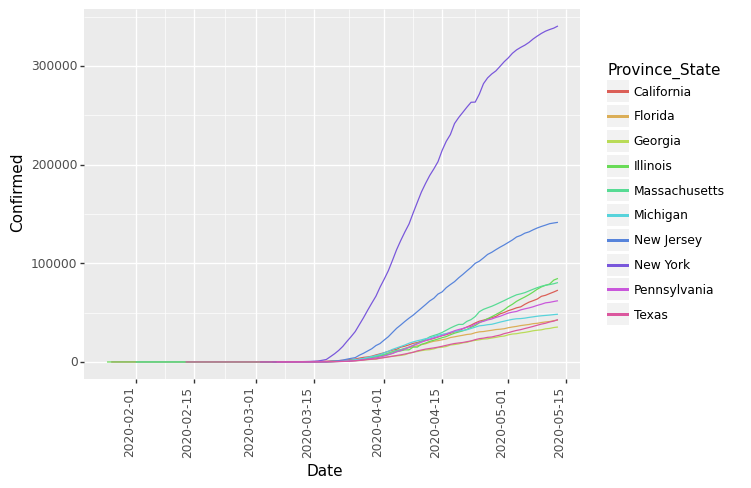

<ggplot: (-9223372036537981468)>

In [42]:
(p9.ggplot(data=jhu_state[jhu_state['Province_State'].isin(jhu_largest_state['Province_State'])],
           mapping=p9.aes(x='Date',
                          y='Confirmed',
                          color='Province_State'))
    + p9.geom_line()
    + p9.theme(axis_text_x = p9.element_text(angle = 90, hjust = 1))
)

## Adding Population Data Per State to Calculate Incident Rate

* Looking at Confirmed cases is not the best feature because population introduces bias
* We will calculate Incident Rate (number of cases per 100'000 people)

In [43]:
## Load 2019 population data from census

population = pd.read_csv('../data/population.csv')
#population.tail()

In [44]:
population.loc[~(population['NAME'].where(population['NAME'].str.contains('Puerto'))).isnull(),'NAME']='Puerto Rico'

In [45]:
population.tail()

,SUMLEV,REGION,DIVISION,STATE,NAME,POPESTIMATE2019,POPEST18PLUS2019,PCNT_POPEST18PLUS
48,40,4,9,53,Washington,7614893,5951832,78.2
49,40,3,5,54,West Virginia,1792147,1432580,79.9
50,40,2,3,55,Wisconsin,5822434,4555837,78.2
51,40,4,8,56,Wyoming,578759,445025,76.9
52,40,X,X,72,Puerto Rico,3193694,2620963,82.1


In [46]:
jhu_state['Population'] = np.zeros(len(jhu_state['Province_State']))
## Add population column per State
for j in range(len(population['NAME'])):
    for i in range(len(jhu_state['Province_State'])):
        if jhu_state.loc[i,'Province_State'] == population.loc[j,'NAME']:
            jhu_state.loc[i,'Population'] = population.loc[j,'POPESTIMATE2019']

In [47]:
jhu_state.tail()

,Date,Province_State,Confirmed,Deaths,Recovered,FIPS,Lat,Long_,Active,Latitude,Longitude,Population
3776,2020-05-13,Virginia,26746.0,928.0,0.0,6908162.0,4996.297993,-10442.323661,25818.0,0.0,0.0,8535519.0
3777,2020-05-13,Washington,17512.0,974.0,0.0,2158574.0,1842.117670,-4708.049596,16538.0,0.0,0.0,7614893.0
3778,2020-05-13,West Virginia,1398.0,58.0,0.0,2900948.0,2018.176519,-4191.713732,1340.0,0.0,0.0,1792147.0
3779,2020-05-13,Wisconsin,10902.0,421.0,0.0,3889975.0,3060.112788,-6193.512168,10481.0,0.0,0.0,5822434.0
3780,2020-05-13,Wyoming,688.0,7.0,0.0,1322540.0,947.158755,-2359.957083,681.0,0.0,0.0,578759.0


In [48]:
## Calculate confirmed cases per 100,000 people

jhu_state['Incidence'] = jhu_state['Confirmed']/jhu_state['Population']*100000

In [49]:
jhu_state.tail()

,Date,Province_State,Confirmed,Deaths,Recovered,FIPS,Lat,Long_,Active,Latitude,Longitude,Population,Incidence
3776,2020-05-13,Virginia,26746.0,928.0,0.0,6908162.0,4996.297993,-10442.323661,25818.0,0.0,0.0,8535519.0,313.349428
3777,2020-05-13,Washington,17512.0,974.0,0.0,2158574.0,1842.117670,-4708.049596,16538.0,0.0,0.0,7614893.0,229.970401
3778,2020-05-13,West Virginia,1398.0,58.0,0.0,2900948.0,2018.176519,-4191.713732,1340.0,0.0,0.0,1792147.0,78.006994
3779,2020-05-13,Wisconsin,10902.0,421.0,0.0,3889975.0,3060.112788,-6193.512168,10481.0,0.0,0.0,5822434.0,187.241281
3780,2020-05-13,Wyoming,688.0,7.0,0.0,1322540.0,947.158755,-2359.957083,681.0,0.0,0.0,578759.0,118.875041


In [50]:
## Delete unnecessary columns
jhu_state = jhu_state.drop(['FIPS','Lat','Long_','Latitude','Longitude'],axis=1)

In [51]:
latest = jhu_state.loc[jhu_state['Date'] == '2020-05-13'] #change according to date as new data is downloaded
latest.head()

,Date,Province_State,Confirmed,Deaths,Recovered,Active,Population,Incidence
3729,2020-05-13,Alabama,10700.0,450.0,0.0,10250.0,4903185.0,218.225500
3730,2020-05-13,Alaska,383.0,10.0,0.0,373.0,731545.0,52.354947
3731,2020-05-13,Arizona,12216.0,595.0,0.0,11621.0,7278717.0,167.831776
3732,2020-05-13,Arkansas,4236.0,97.0,0.0,4139.0,3017804.0,140.366969
3733,2020-05-13,California,72798.0,2957.0,0.0,69841.0,39512223.0,184.241722


In [52]:
# 10 States with highest incident rate (confirmed cases per 100,000 people):
jhu_high_incident_state = latest.nlargest(10,'Incidence')

In [53]:
jhu_high_incident_state

,Date,Province_State,Confirmed,Deaths,Recovered,Active,Population,Incidence
3761,2020-05-13,New York,340661.0,27477.0,0.0,313184.0,19453561.0,1751.149828
3759,2020-05-13,New Jersey,141560.0,9714.0,0.0,131846.0,8882190.0,1593.751091
3750,2020-05-13,Massachusetts,80497.0,5315.0,0.0,75182.0,6892503.0,1167.892129
3769,2020-05-13,Rhode Island,11835.0,462.0,0.0,11373.0,1059361.0,1117.182906
3735,2020-05-13,Connecticut,34855.0,3125.0,0.0,31730.0,3565287.0,977.621156
3737,2020-05-13,District of Columbia,6584.0,350.0,0.0,6234.0,705749.0,932.909576
3736,2020-05-13,Delaware,6952.0,247.0,0.0,6705.0,973764.0,713.930685
3747,2020-05-13,Louisiana,32662.0,2381.0,0.0,30281.0,4648794.0,702.590822
3742,2020-05-13,Illinois,84694.0,3792.0,0.0,80902.0,12671821.0,668.364870
3749,2020-05-13,Maryland,34812.0,1809.0,0.0,33003.0,6045680.0,575.816120


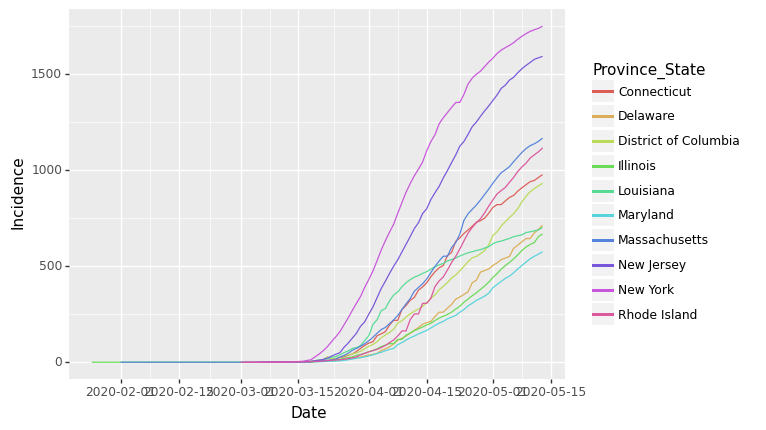

<ggplot: (-9223372036548934926)>

In [54]:
(p9.ggplot(data=jhu_state[jhu_state['Province_State'].isin(jhu_high_incident_state['Province_State'])],
           mapping=p9.aes(x='Date',
                          y='Incidence',
                          color='Province_State'))
    + p9.geom_line()
)

## Calculate Number of days elapsed since Incident Rate exceeded 0.5 per State

* We will use this as a feature in our dataset, since date is an important metric in predicting the incidence rate

In [55]:
## Compute number of days elapsed since incident rate crossed threshold of 0.5

threshold = 0.5
new_data = pd.DataFrame()
States = np.unique(jhu_state['Province_State'])

for state in States:
    state_data = jhu_state.groupby(['Province_State']).get_group(state)
    cond = (state_data['Incidence'] > threshold) & (state_data['Incidence'].shift(1) <= threshold)
    d = state_data[cond]
    thresh = d['Date'].nsmallest(1,keep='first')
    basedate = thresh
    if d.empty:
        state_data['Elapsed_Days'] = 0
    else:
        state_data['Elapsed_Days'] = np.hstack([(date - basedate).dt.days for date in state_data['Date']])
    new_data = new_data.append(state_data)
    #cross_row_inds = d[(d['Date'] >= START_TIME) & (d['Date'] <= END_TIME)].index

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [56]:
## Verifying

#threshold = 0.5

#state_data = jhu_state.groupby(['Province_State']).get_group('California')
#cond = (state_data['Incidence'] > threshold) & (state_data['Incidence'].shift(1) <= threshold)
#d = state_data[cond]
#thresh = d['Date'].nsmallest(1,keep='first')
#basedate = thresh
#if d.empty:
#    state_data['Elapsed_Days'] = 0
#else:
#    state_data['Elapsed_Days'] = np.hstack([(date - basedate).dt.days for date in state_data['Date']])
#state_data

In [57]:
jhu_state = new_data.sort_index(0)
neg_idx = jhu_state.index[jhu_state['Elapsed_Days'] < 0]
jhu_state.loc[neg_idx,'Elapsed_Days'] = 0

In [58]:
jhu_state

,Date,Province_State,Confirmed,Deaths,Recovered,Active,Population,Incidence,Elapsed_Days
0,2020-01-22,Washington,1.0,0.0,0.0,0.0,7614893.0,0.013132,0
1,2020-01-23,Washington,1.0,0.0,0.0,0.0,7614893.0,0.013132,0
2,2020-01-24,Washington,1.0,0.0,0.0,0.0,7614893.0,0.013132,0
3,2020-01-25,Illinois,1.0,0.0,0.0,0.0,12671821.0,0.007892,0
4,2020-01-25,Washington,1.0,0.0,0.0,0.0,7614893.0,0.013132,0
...,...,...,...,...,...,...,...,...,...
3776,2020-05-13,Virginia,26746.0,928.0,0.0,25818.0,8535519.0,313.349428,59
3777,2020-05-13,Washington,17512.0,974.0,0.0,16538.0,7614893.0,229.970401,70
3778,2020-05-13,West Virginia,1398.0,58.0,0.0,1340.0,1792147.0,78.006994,52
3779,2020-05-13,Wisconsin,10902.0,421.0,0.0,10481.0,5822434.0,187.241281,59


## Add Shelter-in-Place Index from Safegraph

* We will use percentage of people staying home as a feature in our dataset to predict the incident rate
* The percentage staying home dataset is downloaded from Rill Data who computed the percentages from Safegraph data. This way we avoided downloading 60GB of data from Safegraph

In [61]:
## Add percentage staying home feature from Safegraph

percentage_home = pd.read_csv('../data/safegraph.csv')
date = percentage_home['__timestamp'].str.split(" ", n = 1, expand = True) 
percentage_home['Date'] = pd.to_datetime(date[0]) 
percentage_home = percentage_home.drop(columns=['__timestamp'])
percentage_home = percentage_home.rename(columns={percentage_home.columns[1]:'percentage_home'})
percentage_home

,state,percentage_home,Date
0,Puerto Rico,69.594465,2020-04-05
1,Puerto Rico,67.106363,2020-04-10
2,Puerto Rico,66.412555,2020-04-11
3,Puerto Rico,66.190164,2020-04-12
4,Puerto Rico,65.091807,2020-04-19
...,...,...,...
7340,Mississippi,15.938000,2020-01-31
7341,Mississippi,15.869747,2020-02-28
7342,Alabama,15.754319,2020-01-31
7343,Alabama,15.504751,2020-01-17


In [62]:
jhu_state['Percentage_Home'] = np.zeros(len(jhu_state))
for j in range(len(jhu_state['Province_State'])):
    cond = (jhu_state.loc[j,'Province_State'] == percentage_home['state']) & (jhu_state.loc[j,'Date'] == percentage_home['Date'])
    idx, = np.where(cond)
    if idx.shape[0] == 0: 
        jhu_state.loc[j,'Percentage_Home'] = np.nan ##Safegraph missing data for some states after 2020-05-09
    else:
        jhu_state.loc[j,'Percentage_Home'] = percentage_home.loc[idx[0],'percentage_home']

In [63]:
jhu_state.tail()

,Date,Province_State,Confirmed,Deaths,Recovered,Active,Population,Incidence,Elapsed_Days,Percentage_Home
3776,2020-05-13,Virginia,26746.0,928.0,0.0,25818.0,8535519.0,313.349428,59,36.601492
3777,2020-05-13,Washington,17512.0,974.0,0.0,16538.0,7614893.0,229.970401,70,39.952959
3778,2020-05-13,West Virginia,1398.0,58.0,0.0,1340.0,1792147.0,78.006994,52,29.465020
3779,2020-05-13,Wisconsin,10902.0,421.0,0.0,10481.0,5822434.0,187.241281,59,35.318540
3780,2020-05-13,Wyoming,688.0,7.0,0.0,681.0,578759.0,118.875041,59,31.452150


Some states are missing data after May 9. This is due to an update Safegraph had on May 9 which caused Rill data to not being able to update their percentage calculation correctly. We have reported the issue to Rill Data and it will be fixed. In the meantime, we have excluded the states who did not have percentage staying home after May 9.

In [64]:
is_NaN = jhu_state.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = jhu_state[row_has_NaN]


In [65]:
print(jhu_state.shape)
print(jhu_state[row_has_NaN].shape)

(3781, 10)
(28, 10)


In [66]:
jhu_state = jhu_state.dropna(axis=0).reset_index()
print(jhu_state.shape)

(3753, 11)


In [67]:
print(np.unique(rows_with_NaN['Province_State']))
rows_with_NaN

['Alabama' 'Alaska' 'Arizona' 'Arkansas' 'California' 'Colorado'
 'Connecticut']


,Date,Province_State,Confirmed,Deaths,Recovered,Active,Population,Incidence,Elapsed_Days,Percentage_Home
3573,2020-05-10,Alabama,9889.0,393.0,0.0,9496.0,4903185.0,201.685231,55,NaN
3574,2020-05-10,Alaska,379.0,10.0,0.0,369.0,731545.0,51.808159,53,NaN
3575,2020-05-10,Arizona,11119.0,536.0,0.0,10583.0,7278717.0,152.760438,52,NaN
3576,2020-05-10,Arkansas,4012.0,91.0,0.0,3921.0,3017804.0,132.944353,56,NaN
3577,2020-05-10,California,67600.0,2716.0,0.0,64884.0,39512223.0,171.086299,59,NaN
3578,2020-05-10,Colorado,19703.0,971.0,0.0,18732.0,5758736.0,342.141053,60,NaN
3579,2020-05-10,Connecticut,33554.0,2967.0,0.0,30587.0,3565287.0,941.130405,57,NaN
3625,2020-05-11,Alabama,10164.0,403.0,0.0,9761.0,4903185.0,207.293830,56,NaN
3626,2020-05-11,Alaska,379.0,10.0,0.0,369.0,731545.0,51.808159,54,NaN
3627,2020-05-11,Arizona,11383.0,542.0,0.0,10841.0,7278717.0,156.387451,53,NaN


#### We will be using dataset from January to May 9 as our training Set. Once the Rill data is corrected, we will use Data from May 9 to May 30 as our Test data and we will try to predict top 5 States who will see the most increase in the incidence rate

In [72]:
## Training Data
X_tr = jhu_state.loc[:,['Province_State','Population','Elapsed_Days','Percentage_Home']]
y_tr = jhu_state.loc[:,'Incidence']

In [73]:
print(X_tr.shape)
print(y_tr.shape)

(3753, 4)
(3753,)


In [74]:
X_tr.head()

,Province_State,Population,Elapsed_Days,Percentage_Home
0,Washington,7614893.0,0,22.113481
1,Washington,7614893.0,0,23.233285
2,Washington,7614893.0,0,22.260950
3,Illinois,12671821.0,0,25.471592
4,Washington,7614893.0,0,26.418402


In [75]:
y_tr.head()

0    0.013132
1    0.013132
2    0.013132
3    0.007892
4    0.013132
Name: Incidence, dtype: float64

In [79]:
compression_opts = dict(method='zip',archive_name='../data/X_tr.csv')  
X_tr.to_csv('../data/X_tr.csv', index=False)  
compression_opts = dict(method='zip',archive_name='../data/y_tr.csv')  
y_tr.to_csv('../data/y_tr.csv', index=False)  